In [1]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist
import scipy.stats
import seaborn as sns


### Load Data

In [2]:
roles_wide = pd.read_csv("../../../dataV2/combined_V1_V2.csv", na_filter=False)
roles_wide.drop("Unnamed: 0", inplace=True, axis=1)

roles_wide.rename({"Sentence": "sentence", "Arg.Phrase": "arg"}, axis=1, inplace=True)

properties_list = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

print(roles_wide.shape)
roles_wide["combined_labels"] = roles_wide["combined_labels"].apply(lambda x: eval(x))
roles_wide.head()


(28820, 16)


,Sentence.ID,Roleset,Gram.Func,sentence,Predicate,Split,arg,Arg.Stripped,arg_idx,verb_idx,structure,decomp_version,Pred.Lemma,modified_sentence,Arg.Parse,combined_labels
0,0003_21,impose.01,nsubj,"In July , a gradual ban was imposed by the Env...",was imposed by,test,a gradual ban,a ban,"(3, 6)","(6, 9)",passive_full,V1,impose,1,,"[1.0, 1.0, 3.0, 1.0, 5.0, 1.0, 5.0, 1.0, 1.0, ..."
1,0003_21,impose.01,dobj,"In July , a gradual ban was imposed by the Env...",was imposed by,train,the Environmental Protection Agency,the Environmental Protection Agency,"(9, 13)","(6, 9)",passive_full,V1,impose,1,,"[5.0, 1.0, 3.0, 1.0, 5.0, 5.0, 5.0, 5.0, 1.0, ..."
2,0003_29,have.03,nsubj,No bearing on our work force today is had by it .,is had by,train,No bearing on our work force today,no bearing,"(0, 7)","(7, 10)",passive_full,V1,have,1,,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,0003_29,have.03,dobj,No bearing on our work force today is had by it .,is had by,test,it,It,"(10, 11)","(7, 10)",passive_full,V1,have,1,,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 3.0, 2.0, ..."
4,0003_9,lead.02,nsubj,A team of researchers from the National Cancer...,was led by,train,A team of researchers from the National Cancer...,a team,"(0, 19)","(19, 22)",passive_full,V1,lead,1,,"[5.0, 3.0, 3.0, 1.0, 3.0, 3.0, 5.0, 3.0, 1.0, ..."


In [3]:
eval_df = roles_wide.loc[
    (roles_wide["decomp_version"] == "V2") & \
    (roles_wide["Split"] == "test")
    ][["Sentence.ID"]].reset_index().drop_duplicates()

print(eval_df.shape)
eval_df.head()


(1748, 2)


,index,Sentence.ID
0,14299,en-ud-test.conllu 1002
1,14300,en-ud-test.conllu 1002
2,14301,en-ud-test.conllu 1002
3,14302,en-ud-test.conllu 1002
4,14303,en-ud-test.conllu 1004


In [4]:
proto_agent = ['awareness', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']
proto_patient = ["changes_state", "changes_possession"]


### roberta-dropout=0.1

In [5]:
contributions_df = pd.read_csv("roberta_gcd_contributions.csv", index_col=0)[
    ["index", "span", "property", "gram", "structure", "class", "per_token_contribution", "proto-role property"]
]
contributions_df = pd.merge(contributions_df, eval_df, on="index").drop(columns=["index"])
contributions_df.head()


,span,property,gram,structure,class,per_token_contribution,proto-role property,Sentence.ID
0,argument,awareness,nsubj,active,negative,-0.000000,proto-agent,en-ud-test.conllu 1002
1,argument,awareness,dobj,active,negative,0.428111,proto-agent,en-ud-test.conllu 1002
2,argument,awareness,nsubj,active,negative,0.124684,proto-agent,en-ud-test.conllu 1004
3,argument,awareness,nsubj,active,negative,-0.000000,proto-agent,en-ud-test.conllu 1008
4,argument,awareness,nsubj,active,negative,-0.000000,proto-agent,en-ud-test.conllu 1009


In [6]:
contributions_df = contributions_df.loc[
    (contributions_df["gram"] != "iobj")  
    # & (contributions_df["span"] != "modifier") & 
    # (contributions_df["span"] != "other_arguments")
]


In [7]:
pa = contributions_df.loc[
    (contributions_df["proto-role property"] == "proto-agent") & \
    (contributions_df["property"] != "changes_location")
    ].drop(columns="proto-role property")

pp = contributions_df.loc[
    (contributions_df["proto-role property"] == "proto-patient") & \
    (contributions_df["property"] != "changes_location")
    ].drop(columns="proto-role property")

pl = contributions_df.loc[
    (contributions_df["property"] == "changes_location")
    ].drop(columns=["proto-role property"])


### Considering every sentence as its own distribution  

In [10]:
def get_dist(dist):
    d = dist.pivot_table(
        columns=["class", "structure", "gram", "span"],
        index=["Sentence.ID", "property"],
        values="per_token_contribution",
        ).fillna(0)

    d.columns = d.columns.to_flat_index()
    d["distr"] = d[d.columns].to_numpy().tolist()
    d = d.reset_index()[["Sentence.ID", "property", "distr",]].pivot(
        index="Sentence.ID", columns="property", values="distr").reset_index(drop=True)
    d = np.array(d.to_numpy().tolist())
    d = d.transpose(2, 0, 1).reshape(d.shape[2], -1).T
    print(d.shape)
    return d

agent = get_dist(pa)
patient = get_dist(pp)
changes_location = get_dist(pl)


(1918, 32)
(548, 32)
(274, 32)


In [11]:
def KL(a, b):
    return (np.sum(a * np.log(a / b)) + np.sum(b * np.log(b / a)))/2
    # return np.sum(a * np.log(a / b))

eps = 1e-10
a = agent / agent.sum(-1, keepdims=True) + eps
p = patient / patient.sum(-1,  keepdims=True) + eps
c = changes_location / changes_location.sum(-1, keepdims=True) + eps

dists = np.zeros((3, 3))
sets = [a, p, c]
for i in range(3):
    for j in range(i, 3):
        if i == j:
            dists[j, i] = cdist(sets[i], sets[j], KL)[~np.eye(len(sets[i]), dtype=bool)].mean()
        else:
            dists[j, i] = cdist(sets[i], sets[j], KL).mean()

dists


array([[10.32809575,  0.        ,  0.        ],
       [13.42561814, 10.26373806,  0.        ],
       [11.22349991,  9.67055955,  8.72719621]])

<Axes: >

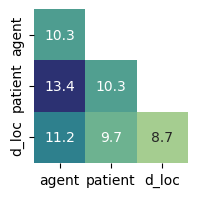

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2,2)) 

sns.heatmap(dists, annot=True, mask=np.array(dists == 0), square=True,
            xticklabels=["agent", "patient", "d_loc"], 
            yticklabels=["agent", "patient", "d_loc"], ax=ax, 
            fmt=".1f",
            cbar=False, cmap="crest")


In [16]:
def get_dist(dist):
    d = dist.pivot_table(
        columns=["class", "structure", "gram", "span"],
        index=["Sentence.ID", "property"],
        values="per_token_contribution",
        ).fillna(0)

    d.columns = d.columns.to_flat_index()
    d["distr"] = d[d.columns].to_numpy().tolist()
    d = d.reset_index()[["Sentence.ID", "property", "distr",]].pivot(
        index="Sentence.ID", columns="property", values="distr").reset_index(drop=True)
    d = np.array(d.to_numpy().tolist())
    d = d.transpose(1, 0, 2)
    print(d.shape)
    return d

agent = get_dist(pa)
patient = get_dist(pp)
changes_location = get_dist(pl)


(7, 274, 32)
(2, 274, 32)
(1, 274, 32)


In [17]:
all_properties = np.concatenate([agent, patient, changes_location])
all_properties = all_properties / all_properties.sum(-1, keepdims=True) + eps

dists = np.zeros((10, 10))
for i in range(10):
    for j in range(i, 10):
        dists[j, i] = cdist(all_properties[i], all_properties[j], KL).mean()

dists


array([[10.28623422,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [10.71072368, 10.45403075,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [10.59845774, 10.31404221, 10.15862404,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [11.08877543, 10.87742818, 10.73615065, 11.28351644,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 9.77574844,  9.68256831,  9.51638994, 10.08573698,  8.83395353,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [10.08023647, 10.46739202, 10.37063516, 10.83598924,  9.55858765,
         9.84743473,  0.        ,  0.        ,  0.        ,  0.        ],
       [10.26092702, 10.75855972, 10.6565052 , 11.12313336,  9.81702591,
        10.04838793, 10.22223892,  0.        

<Axes: >

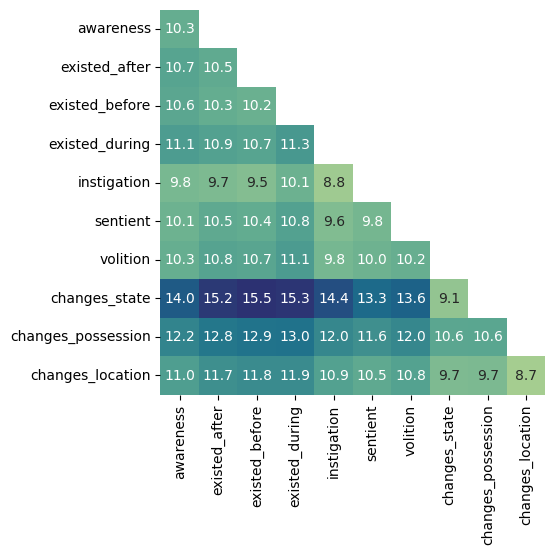

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5)) 

labels = proto_agent + proto_patient + ["changes_location"]

sns.heatmap(dists, annot=True, mask=np.array(dists == 0), square=True,
            xticklabels=labels, 
            yticklabels=labels, ax=ax, 
            fmt=".1f",
            cbar=False, cmap="crest")


### Considering every feature as its own distribution 

In [19]:
def get_dist(dist):
    d = dist.pivot_table(
        columns=["class", "structure", "gram", "span"],
        index=["Sentence.ID", "property"],
        values="per_token_contribution",
        )

    d.columns = d.columns.to_flat_index()
    d["distr"] = d[d.columns].to_numpy().tolist()
    d = d.reset_index()[["Sentence.ID", "property", "distr",]].pivot(
        index="Sentence.ID", columns="property", values="distr").reset_index(drop=True)

    d = np.array(d.to_numpy().tolist()).transpose(1, 0, 2)
    d = d[~np.isnan(d)].reshape(d.shape[0], -1)
    print(d.shape)
    return d

agent = get_dist(pa)
patient = get_dist(pp)
changes_location = get_dist(pl)


(7, 3984)
(2, 3984)
(1, 3984)


In [ ]:
def KL(a, b):
    return np.sum(a * np.log(a / b))

eps = 1e-10
a = agent / agent.sum(-1, keepdims=True) + eps
p = patient / patient.sum(-1,  keepdims=True) + eps
c = changes_location / changes_location.sum(-1, keepdims=True) + eps

dists = np.empty((3, 3))
sets = [a, p, c]
for i in range(3):
    for j in range(3):
        if i == j:
            dists[i, j] = cdist(sets[i], sets[j], KL)[~np.eye(len(sets[i]), dtype=bool)].mean()
        else:
            dists[i, j] = cdist(sets[i], sets[j], KL).mean()

dists


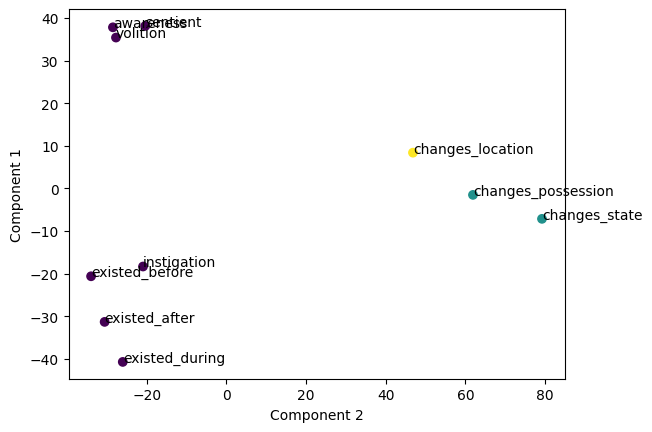

In [21]:
from sklearn.decomposition import PCA
import sklearn.manifold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = np.concatenate([agent, patient, changes_location])
y = np.concatenate([np.zeros(7, ), np.ones(2, ), 2 * np.ones(1,)])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)  
X_embedded = pca.fit_transform(X_scaled)

# X_embedded = sklearn.manifold.TSNE(n_components=2, learning_rate='auto',
#                   init='random', perplexity=2).fit_transform(X)
# X_embedded = sklearn.manifold.SpectralEmbedding(n_components=2, affinity="rbf").fit_transform(X)

fig, ax = plt.subplots()

ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)
ax.set_ylabel('Component 1')
ax.set_xlabel('Component 2')

labels = proto_agent + proto_patient + ["changes_location"]

for i, txt in enumerate(labels):
    ax.annotate(txt, X_embedded[i])
